In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.model_selection import KFold

sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.2, rc={'lines.markersize': 8})

In [2]:
folds = 8
indexes = list(range(48))
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
kf.get_n_splits(indexes)

FOLD_DICT = {k+1: list(v[1]+1) for k, v in enumerate(list(kf.split(indexes)))}

In [3]:
FOLD_DICT

{1: [25, 27, 28, 38, 41, 44],
 2: [4, 5, 9, 13, 20, 26],
 3: [7, 14, 18, 34, 40, 46],
 4: [10, 16, 17, 30, 33, 47],
 5: [1, 6, 12, 31, 32, 35],
 6: [2, 3, 22, 36, 37, 45],
 7: [11, 19, 23, 24, 42, 48],
 8: [8, 15, 21, 29, 39, 43]}

In [7]:
K = -1
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_th{threshold}_{variant}mbps'.format(K=K, threshold='{threshold}', variant='{variant}')
VIDEO_LIST = [0,2,4]
VIDEO_TITLES = ['Sandwich', 'Spotlight', 'Surf']
# USER_LIST = range
# QUALITIES = [1, 2, 3, 4, 5]
PREFETCH_FILE_TMPL = 'log_seg_u{user}_prefetch.txt'
NO_PREFETCH_FILE_TMPL = 'log_seg_u{user}_no_prefetch.txt'
# VARIANTS = {'dyn_vp_cc': 'NCP', 'dyn_vp_hw': 'HWP', 'dyn_vp_sc': 'NSP'}
VARIANTS = [10, 15]
THRESHOLDS = [90]
SEG_DUR = 1.065

results_list = []
prefetch_flag = False

for var in VARIANTS:
    for th in THRESHOLDS:
        for v in VIDEO_LIST:
            for fold in FOLD_DICT:
                for u in FOLD_DICT[fold]:
                    for file_tmpl in [PREFETCH_FILE_TMPL, NO_PREFETCH_FILE_TMPL]:
                        prefetch_flag = not prefetch_flag
                        with open(f'{LOGS_PATH_TMP.format(variant=var, threshold=th)}/fold{fold}/{v}/{file_tmpl.format(user=u)}', 'r') as p_file:
                            p_times = [float(t.strip()) for t in p_file.readlines()]
                            p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'seg_resp_time'])
                            p_df['seg_resp_time'] = p_times
                            p_df['segment'] = p_df.index + 1
                            p_df['video'] = v
                            p_df['user'] = u
                            p_df['prefetch'] = f'{var}mbps_{th}' if prefetch_flag else f'NO_PREFETCH_{var}mbps_{th}'
                            p_df['threshold'] = th
                            results_list.append(p_df)
                
results_df = pd.concat(results_list, ignore_index=True)

In [8]:
results_df

,video,user,prefetch,seg_resp_time,segment,threshold
0,0,25,10mbps_90,0.196778,1,90
1,0,25,10mbps_90,0.627876,2,90
2,0,25,10mbps_90,2.273094,3,90
3,0,25,10mbps_90,2.647477,4,90
4,0,25,10mbps_90,1.601760,5,90
...,...,...,...,...,...,...
17275,4,43,NO_PREFETCH_15mbps_90,1.042161,26,90
17276,4,43,NO_PREFETCH_15mbps_90,0.978029,27,90
17277,4,43,NO_PREFETCH_15mbps_90,0.967741,28,90
17278,4,43,NO_PREFETCH_15mbps_90,0.924194,29,90


In [9]:
stats = pd.DataFrame(group.describe().rename(columns={'seg_resp_time': prefetch}).squeeze()
                         for prefetch, group in results_df[['prefetch', 'seg_resp_time']].groupby(['prefetch'])).T
# stats['change'] = stats.pct_change(axis='columns').iloc[:,-1:]
stats

,10mbps_90,15mbps_90,NO_PREFETCH_10mbps_90,NO_PREFETCH_15mbps_90
count,4320.000000,4320.000000,4320.000000,4320.000000
mean,1.490990,1.113299,0.739912,0.758598
std,0.762090,0.495467,0.132697,0.149008
min,0.150703,0.151898,0.530367,0.528922
25%,1.057072,0.836829,0.624560,0.608393
50%,1.438984,1.104438,0.712207,0.761524
75%,1.876023,1.383872,0.850358,0.888033
max,4.117659,2.795447,1.237870,1.258292


In [10]:
# k_unique = results_df['k'].unique().tolist()
v_unique = results_df['video'].unique().tolist()

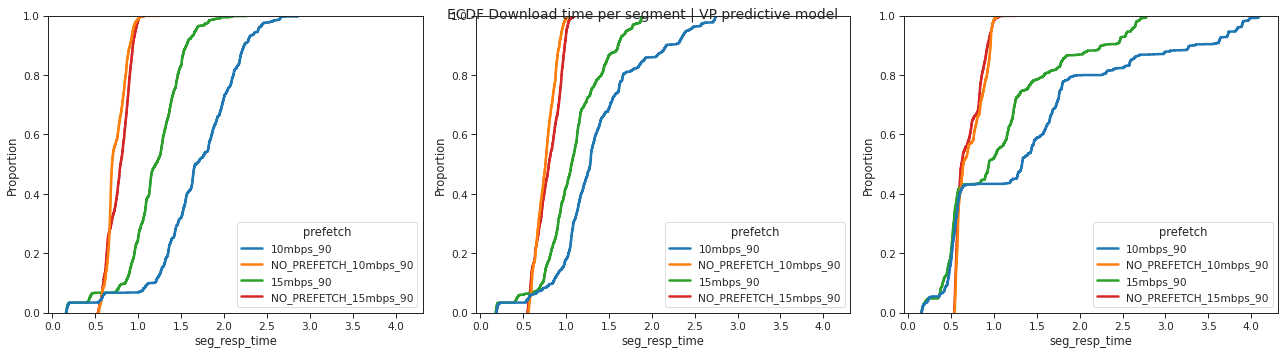

In [11]:
fig, axes = plt.subplots(len(THRESHOLDS), len(v_unique), figsize=(18,5), sharex=True)

for i in range(len(THRESHOLDS)):
    for j in range(len(v_unique)):
#         axis = axes[i][j]
        axis = axes[j]
        sns.ecdfplot(
            data=results_df[(results_df['video'] == v_unique[j]) & (results_df['threshold'] == THRESHOLDS[i])], 
            x="seg_resp_time", 
            linewidth=2.5, 
            hue="prefetch",
            legend=True,
            ax=axis
        )

#         axis.lines[0].set_linestyle("--")
#         leg = axis.get_legend()
#         leg_texts = [t.get_text() for t in leg.texts]
#         leg.get_lines()[leg_texts.index('NO_PREFETCH')].set_linestyle("--")
#         axis.set_title(f'Video {VIDEO_TITLES[j]}')
#         axis.axvline(x=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
# #         axis.set_title(f'Video {j*2}')
#         axis.set_xlabel('Download time (s)')
#         axis.get_legend().set_title("")
#         axis.legend(
#             handles=[axis.lines[0], axis.lines[1]],#, axis.lines[1], axis.lines[0], axis.lines[4]], 
#             labels=["NO_PREFETCH", f"NCP_{THRESHOLDS[i]}"]#, f"HWP_{THRESHOLDS[i]}", f"NSP_{THRESHOLDS[i]}", "SEG_DUR"]
#         )
    #     axis.set_xlim(0,2.5)
plt.suptitle(f'ECDF Download time per segment | VP predictive model')
plt.tight_layout()

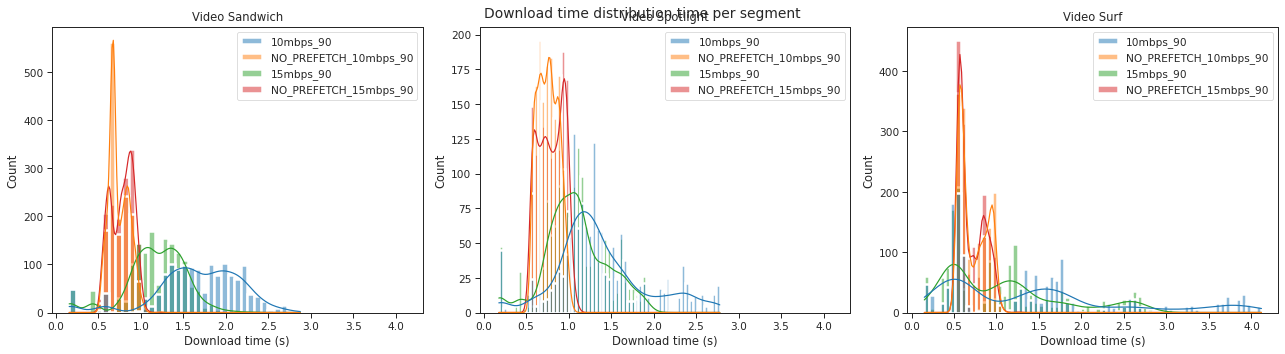

In [12]:
fig, axes = plt.subplots(len(THRESHOLDS), len(v_unique), figsize=(18,5), sharex=True)

for i in range(len(THRESHOLDS)):
    for j in range(len(v_unique)):
#         axis = axes[i][j]
        axis = axes[j]
        sns.histplot(
            data=results_df[(results_df['video'] == v_unique[j]) & (results_df['threshold'] == THRESHOLDS[i])], 
            x="seg_resp_time", 
            linewidth=2.5, 
            hue="prefetch", 
            kde=True, 
            ax=axis
        )

        axis.set_title(f'Video {VIDEO_TITLES[j]}')
#         axis.set_title(f'Video {j*2}')
        axis.set_xlabel('Download time (s)')
        axis.get_legend().set_title("")
    #     axis.set_xlim(0,2.5)
plt.suptitle(f'Download time distribution time per segment')
plt.tight_layout()

In [18]:
PREFETCH_FILE_TMPL = 'log_seg_quality_u{user}_prefetch.txt'
NO_PREFETCH_FILE_TMPL = 'log_seg_quality_u{user}_no_prefetch.txt'

quality_results_list = []
prefetch_flag = False
t_hor = 4
t_vert = 4

for var in VARIANTS:
    for th in THRESHOLDS:
        for v in VIDEO_LIST:
            for fold in FOLD_DICT:
                for u in FOLD_DICT[fold]:
                    for file_tmpl in [PREFETCH_FILE_TMPL, NO_PREFETCH_FILE_TMPL]:
                        prefetch_flag = not prefetch_flag
                        with open(f'{LOGS_PATH_TMP.format(variant=var, threshold=th)}/fold{fold}/{v}/{file_tmpl.format(user=u)}', 'r') as p_file:
                            p_qualities = [[int(x) for x in json.loads(line)] for line in p_file]
                            p_df = pd.DataFrame(p_qualities, columns=[f'tile_{i}' for i in range(t_hor*t_vert)])
                            p_df['segment'] = p_df.index + 1
                            p_df['video'] = v
                            p_df['user'] = u
                            p_df['prefetch'] = f'{var}mpbs_{th}' if prefetch_flag else f'NO_PREFETCH_{var}mbps_{th}'
                            p_df['threshold'] = th
                            quality_results_list.append(p_df)
                
quality_results_df = pd.concat(quality_results_list, ignore_index=True)

In [19]:
quality_results_df

,tile_0,tile_1,tile_2,tile_3,tile_4,tile_5,tile_6,tile_7,tile_8,tile_9,...,tile_11,tile_12,tile_13,tile_14,tile_15,segment,video,user,prefetch,threshold
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,25,10mpbs_90,90
1,2,2,2,1,2,2,2,2,2,2,...,1,1,1,2,1,2,0,25,10mpbs_90,90
2,2,2,1,2,2,2,2,2,1,2,...,2,2,2,2,1,3,0,25,10mpbs_90,90
3,1,2,2,1,2,2,2,2,2,2,...,2,2,1,1,2,4,0,25,10mpbs_90,90
4,2,2,1,1,2,2,2,2,2,2,...,2,1,1,2,1,5,0,25,10mpbs_90,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,1,1,1,1,1,1,1,1,1,2,...,1,2,2,2,1,26,4,43,NO_PREFETCH_15mbps_90,90
17276,1,1,1,1,1,2,1,1,1,2,...,1,1,2,2,1,27,4,43,NO_PREFETCH_15mbps_90,90
17277,1,1,1,1,1,2,1,1,1,2,...,1,1,2,1,1,28,4,43,NO_PREFETCH_15mbps_90,90
17278,1,1,1,1,1,2,1,1,1,2,...,1,1,2,1,1,29,4,43,NO_PREFETCH_15mbps_90,90


Text(246.79375, 0.5, 'Tile')

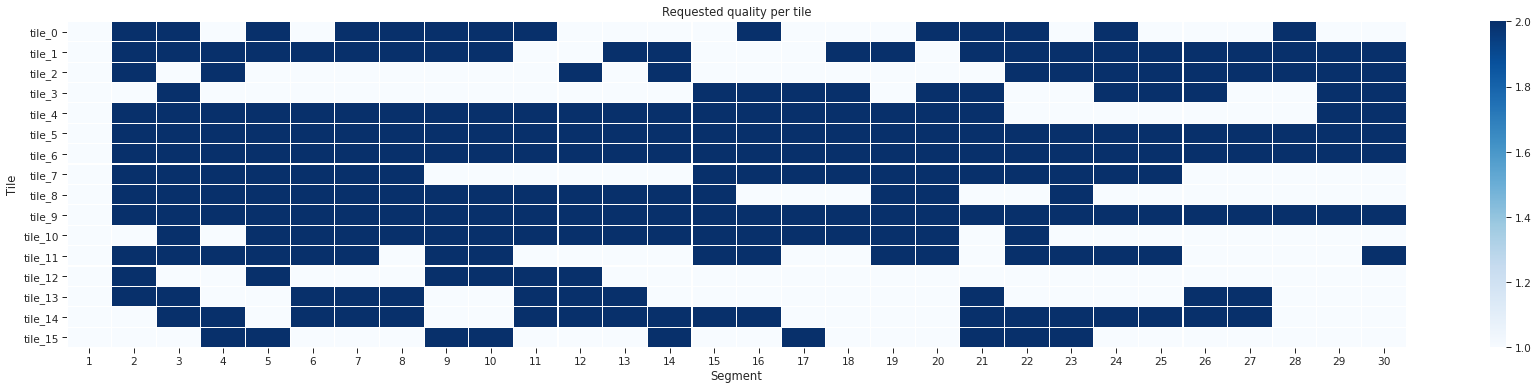

In [20]:
fig, ax = plt.subplots(figsize=(30,6))
u_id = 1
v_id = 0

sns.heatmap(
    data = quality_results_df[
        (quality_results_df['user'] == u_id) & 
        (quality_results_df['video'] == v_id) &
        (quality_results_df['prefetch'] == '10mpbs_90')
    ][['segment']+[f'tile_{i}' for i in range(t_hor*t_vert)]].set_index('segment').T, 
    linewidths=.1, 
    cmap="Blues",
    vmin=1.,
    vmax=2.,
    ax=ax)
ax.set_title('Requested quality per tile')
ax.set_xlabel('Segment')
ax.set_ylabel('Tile')

Text(246.79375, 0.5, 'Tile')

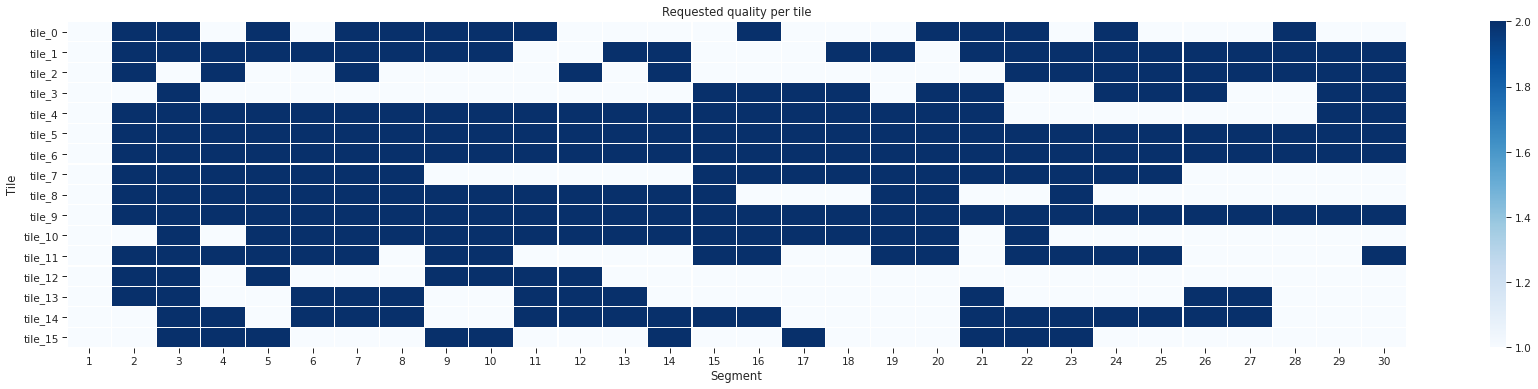

In [21]:
fig, ax = plt.subplots(figsize=(30,6))
u_id = 1
v_id = 0

sns.heatmap(
    data = quality_results_df[
        (quality_results_df['user'] == u_id) & 
        (quality_results_df['video'] == v_id) &
        (quality_results_df['prefetch'] == '15mpbs_90')
    ][['segment']+[f'tile_{i}' for i in range(t_hor*t_vert)]].set_index('segment').T, 
    linewidths=.1, 
    cmap="Blues",
    vmin=1.,
    vmax=2.,
    ax=ax)
ax.set_title('Requested quality per tile')
ax.set_xlabel('Segment')
ax.set_ylabel('Tile')

Text(246.79375, 0.5, 'Tile')

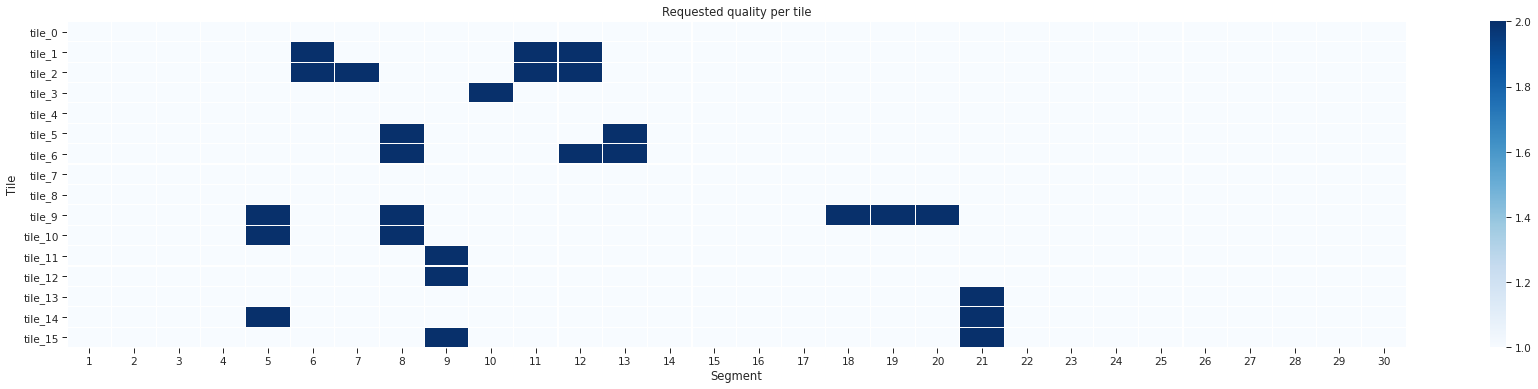

In [25]:
fig, ax = plt.subplots(figsize=(30,6))
sns.heatmap(
    data = quality_results_df[
        (quality_results_df['user'] == u_id) & 
        (quality_results_df['video'] == v_id) &
        (quality_results_df['prefetch'] == 'NO_PREFETCH_10mbps_90')
    ][['segment']+[f'tile_{i}' for i in range(t_hor*t_vert)]].set_index('segment').T, 
    linewidths=.1, 
    cmap="Blues",
    vmin=1.,
    vmax=2.,
    ax=ax)
ax.set_title('Requested quality per tile')
ax.set_xlabel('Segment')
ax.set_ylabel('Tile')

Text(246.79375, 0.5, 'Tile')

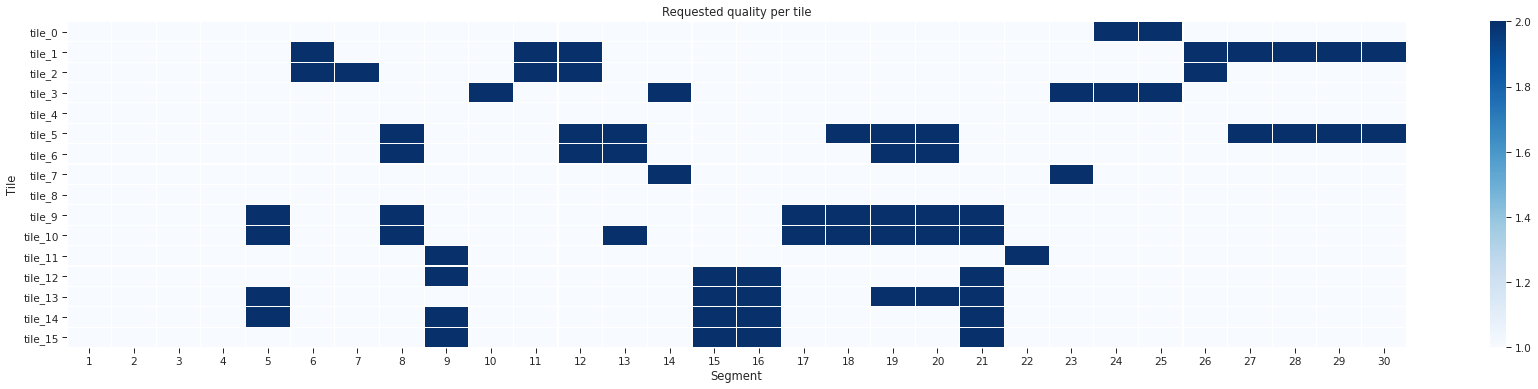

In [26]:
fig, ax = plt.subplots(figsize=(30,6))
sns.heatmap(
    data = quality_results_df[
        (quality_results_df['user'] == u_id) & 
        (quality_results_df['video'] == v_id) &
        (quality_results_df['prefetch'] == 'NO_PREFETCH_15mbps_90')
    ][['segment']+[f'tile_{i}' for i in range(t_hor*t_vert)]].set_index('segment').T, 
    linewidths=.1, 
    cmap="Blues",
    vmin=1.,
    vmax=2.,
    ax=ax)
ax.set_title('Requested quality per tile')
ax.set_xlabel('Segment')
ax.set_ylabel('Tile')

In [28]:
PREFETCH_FILE_TMPL = 'log_seg_quality_u{user}_prefetch.txt'
NO_PREFETCH_FILE_TMPL = 'log_seg_quality_u{user}_no_prefetch.txt'

quality_results_list = []
prefetch_flag = False
t_hor = 4
t_vert = 4

def get_quality_counts(qualities):
    return [qualities.count(1), qualities.count(2)]

for var in VARIANTS:
    for th in THRESHOLDS:
        for v in VIDEO_LIST:
            for fold in FOLD_DICT:
                for u in FOLD_DICT[fold]:
                    for file_tmpl in [PREFETCH_FILE_TMPL, NO_PREFETCH_FILE_TMPL]:
                        prefetch_flag = not prefetch_flag
                        with open(f'{LOGS_PATH_TMP.format(variant=var, threshold=th)}/fold{fold}/{v}/{file_tmpl.format(user=u)}', 'r') as p_file:
                            p_qualities = [get_quality_counts([int(x) for x in json.loads(line)]) for line in p_file]
                            p_df = pd.DataFrame(p_qualities, columns=['lq', 'hq'])
                            p_df['segment'] = p_df.index + 1
                            p_df['video'] = v
                            p_df['user'] = u
                            p_df['prefetch'] = f'{var}mbps_{th}' if prefetch_flag else f'NO_PREFETCH_{var}mbps_{th}'
                            p_df['threshold'] = th
                            quality_results_list.append(p_df)
                
quality_results_df = pd.concat(quality_results_list, ignore_index=True)

In [29]:
quality_results_df

,lq,hq,segment,video,user,prefetch,threshold
0,16,0,1,0,25,10mbps_90,90
1,5,11,2,0,25,10mbps_90,90
2,4,12,3,0,25,10mbps_90,90
3,5,11,4,0,25,10mbps_90,90
4,5,11,5,0,25,10mbps_90,90
...,...,...,...,...,...,...,...
17275,11,5,26,4,43,NO_PREFETCH_15mbps_90,90
17276,11,5,27,4,43,NO_PREFETCH_15mbps_90,90
17277,12,4,28,4,43,NO_PREFETCH_15mbps_90,90
17278,13,3,29,4,43,NO_PREFETCH_15mbps_90,90


In [30]:
quality_results_df[quality_results_df['prefetch'] == 'NO_PREFETCH_10mbps_90'].hq.value_counts()

0     1811
1      749
2      568
3      375
16     314
4      225
5      156
6       65
7       21
8       11
9        9
15       8
11       3
13       2
12       2
10       1
Name: hq, dtype: int64

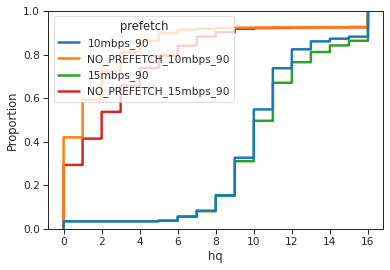

In [31]:
sns.ecdfplot(data=quality_results_df, 
            x="hq", 
            linewidth=2.5, 
            hue="prefetch",
            legend=True,
)

Text(0.5, 1.0, 'NO_PREFETCH | (DASH, CTF, spherical walk) ')

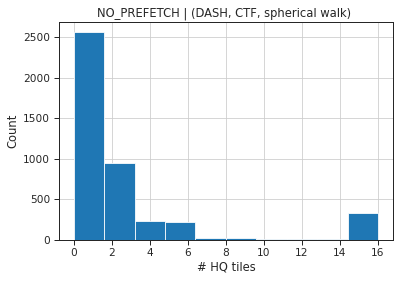

In [32]:
quality_results_df[quality_results_df['prefetch'] == 'NO_PREFETCH_10mbps_90'].hq.hist()
plt.xlabel('# HQ tiles')
plt.ylabel('Count')
plt.title('NO_PREFETCH | (DASH, CTF, spherical walk) ')

In [33]:
quality_results_df[quality_results_df['prefetch'] == 'NO_PREFETCH_10mbps_90'].hq.value_counts()

0     1811
1      749
2      568
3      375
16     314
4      225
5      156
6       65
7       21
8       11
9        9
15       8
11       3
13       2
12       2
10       1
Name: hq, dtype: int64

Text(0.5, 1.0, 'NEAR-CLIENT PREFETCH | (DASH, CTF, spherical walk) ')

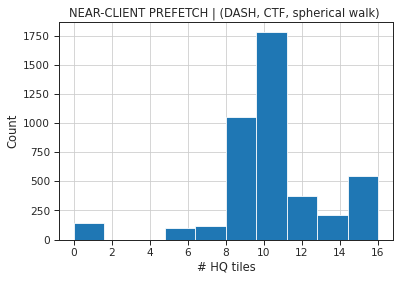

In [36]:
quality_results_df[quality_results_df['prefetch'] == '10mbps_90'].hq.hist()
plt.xlabel('# HQ tiles')
plt.ylabel('Count')
plt.title('NEAR-CLIENT PREFETCH | (DASH, CTF, spherical walk) ')

In [37]:
quality_results_df['hq_ratio'] = quality_results_df.apply(lambda r: r.hq/(r.hq + r.lq), axis=1)
quality_results_df['lq_ratio'] = 1 - quality_results_df['hq_ratio']

In [38]:
quality_results_df

,lq,hq,segment,video,user,prefetch,threshold,hq_ratio,lq_ratio
0,16,0,1,0,25,10mbps_90,90,0.0000,1.0000
1,5,11,2,0,25,10mbps_90,90,0.6875,0.3125
2,4,12,3,0,25,10mbps_90,90,0.7500,0.2500
3,5,11,4,0,25,10mbps_90,90,0.6875,0.3125
4,5,11,5,0,25,10mbps_90,90,0.6875,0.3125
...,...,...,...,...,...,...,...,...,...
17275,11,5,26,4,43,NO_PREFETCH_15mbps_90,90,0.3125,0.6875
17276,11,5,27,4,43,NO_PREFETCH_15mbps_90,90,0.3125,0.6875
17277,12,4,28,4,43,NO_PREFETCH_15mbps_90,90,0.2500,0.7500
17278,13,3,29,4,43,NO_PREFETCH_15mbps_90,90,0.1875,0.8125


Text(0.5, 1.0, 'Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

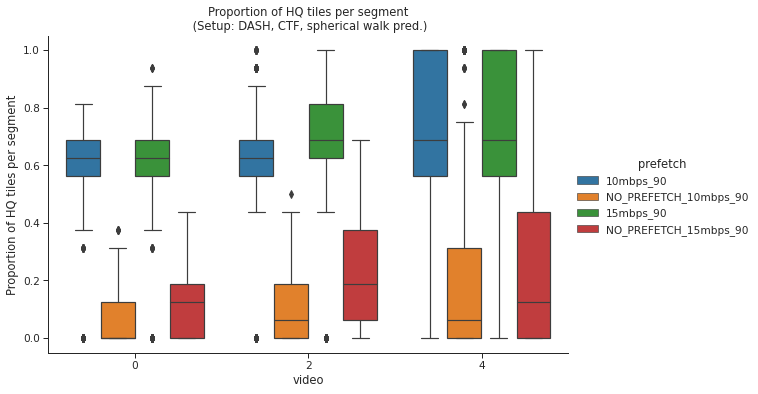

In [39]:
ax = sns.catplot(x="video", y="hq_ratio", hue="prefetch", data=quality_results_df, kind="box", height=5, aspect=1.602)
ax.axes[0][0].set_ylabel('Proportion of HQ tiles per segment')
ax.axes[0][0].set_title('Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

Text(0.5, 1.0, 'Distribution of the number of tiles per segment retrieved in HQ\n (Setup: DASH, CTF, spherical walk pred.)')

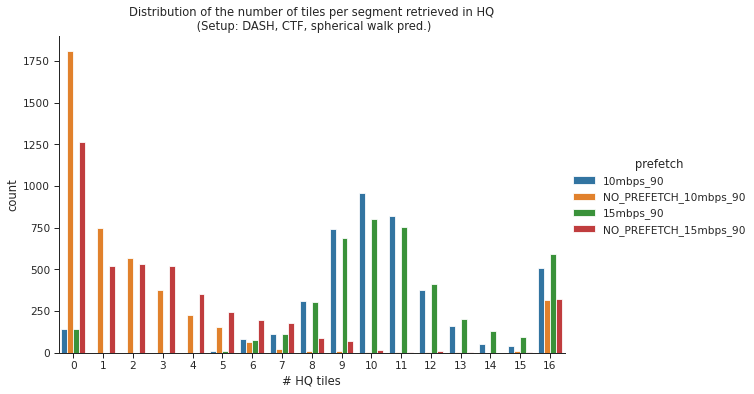

In [40]:
ax = sns.catplot(x="hq", hue="prefetch", data=quality_results_df, kind="count", height=5, aspect=1.602)
ax.axes[0][0].set_xlabel('# HQ tiles')
ax.axes[0][0].set_title('Distribution of the number of tiles per segment retrieved in HQ\n (Setup: DASH, CTF, spherical walk pred.)')

In [26]:
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_lq_pftch_{variant}'.format(K=K, variant='{variant}')
VARIANTS = {'cc': 'NCP_LQ', 'hw': 'HWP_LQ', 'sc': 'NSP_LQ'}
results_lq_list = []

for var in VARIANTS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for file_tmpl in [PREFETCH_FILE_TMPL, NO_PREFETCH_FILE_TMPL]:
                    prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{file_tmpl.format(user=u)}', 'r') as p_file:
                        p_times = [float(t.strip()) for t in p_file.readlines()]
                        p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'seg_resp_time'])
                        p_df['seg_resp_time'] = p_times
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = v
                        p_df['user'] = u
                        p_df['prefetch'] = f'{VARIANTS[var]}' if prefetch_flag else 'NO_PREFETCH'
                        results_lq_list.append(p_df)

results_lq_df = pd.concat(results_lq_list, ignore_index=True)

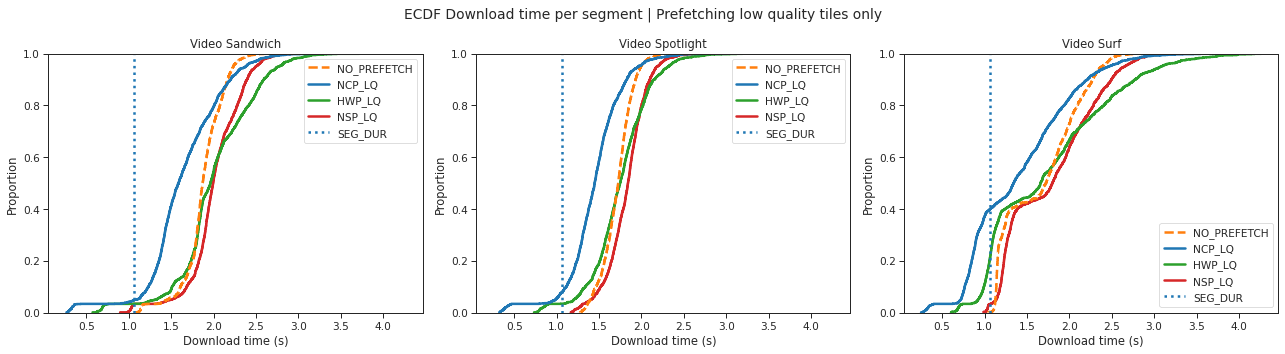

In [27]:
fig, axes = plt.subplots(1, len(v_unique), figsize=(18,5), sharex=True)

for j in range(len(v_unique)):
    axis = axes[j]
    sns.ecdfplot(
        data=results_lq_df[(results_lq_df['video'] == v_unique[j])], 
        x="seg_resp_time", 
        linewidth=2.5, 
        hue="prefetch",
        legend=True,
        ax=axis
    )

    axis.lines[2].set_linestyle("--")
    leg = axis.get_legend()
    leg_texts = [t.get_text() for t in leg.texts]
    leg.get_lines()[leg_texts.index('NO_PREFETCH')].set_linestyle("--")
    axis.set_title(f'Video {VIDEO_TITLES[j]}')
    axis.axvline(x=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
#         axis.set_title(f'Video {j*2}')
    axis.set_xlabel('Download time (s)')
    axis.get_legend().set_title("")
    axis.legend(
        handles=[axis.lines[2], axis.lines[3], axis.lines[1], axis.lines[0], axis.lines[4]], 
        labels=["NO_PREFETCH", f"NCP_LQ", f"HWP_LQ", f"NSP_LQ", "SEG_DUR"]
    )
#     axis.set_xlim(0,2.5)
plt.suptitle(f'ECDF Download time per segment | Prefetching low quality tiles only')
plt.tight_layout()

In [28]:
fig.savefig('ecdf-lq-prefetch.pdf', format='pdf', dpi=300, bbox_inches='tight')

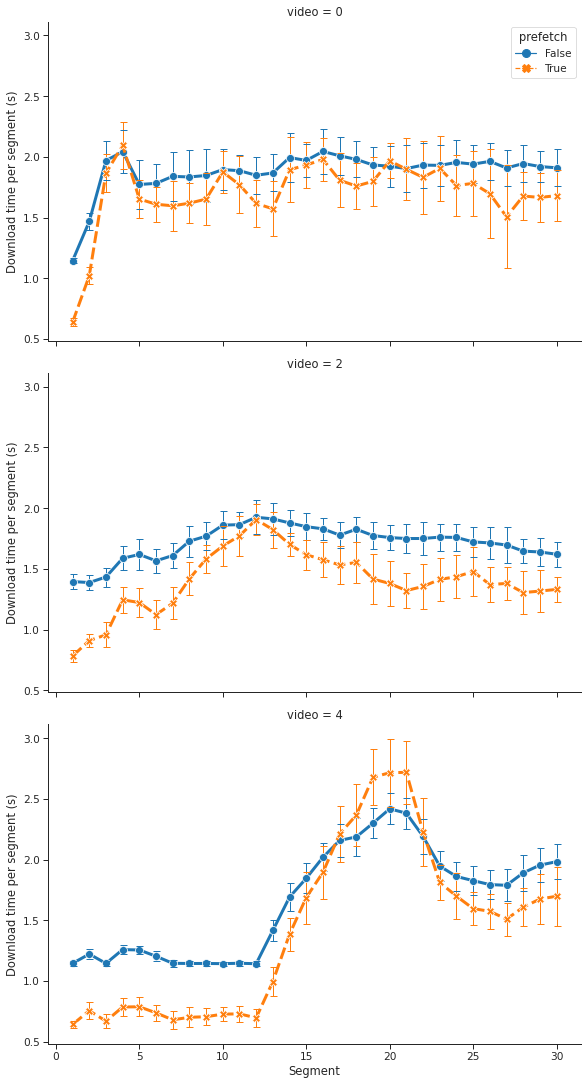

In [11]:
ax = sns.relplot(x="segment", 
                 y="seg_resp_time", 
                 hue="prefetch",
                 style='prefetch',
                 data=results_df, 
                 kind="line",
                 height=5, 
                 aspect=1.618,
                 row ="video",
                 err_style='bars', 
                 err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
                 ci='sd', 
                 markers=True,
                 linewidth=3,
                 facet_kws = {'legend_out': False}
                )
ax.set_axis_labels("Segment", "Download time per segment (s)")#.set(ylim=(0, .5))